In [1]:
import numpy as np
import mne
from utils.loader import unicorn_fs
from utils.feature_extraction import extract_features
from utils.load_dataset import load_dataset, generate_samples
from sklearn.preprocessing import StandardScaler
import pickle
from utils.validation import plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score  
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

mne.set_log_level(verbose='ERROR', return_old_level=False, add_frames=None)

%matplotlib inline
#matplotlib.use("Qt5Agg")

path_dataset = 'data/dataset/playing_listening'
labels = ['baseline', 'relax', 'excited']

In [2]:
# Read dataset and generate samples

dataset = load_dataset(path_dataset, labels)
eeg_baseline = dataset['baseline']
eeg_relax = dataset['relax']
eeg_excited = dataset['excited']


window_duration = 4 # seconds
window_size = window_duration * unicorn_fs # samples
window_overlap = 0.875 # percentage

print('\nBaseline')
eeg_baseline_samples = generate_samples(eeg_baseline, window_size, window_overlap)
print('\nRelax')
eeg_relax_samples = generate_samples(eeg_relax, window_size, window_overlap)
print('\nExcited')
eeg_excited_samples = generate_samples(eeg_excited, window_size, window_overlap)

Loading file: data/dataset/playing_listening\baseline\baseline_playing_listening_excited.csv
Loading file: data/dataset/playing_listening\relax\song_playing_listening_relax.csv
Loading file: data/dataset/playing_listening\excited\song_playing_listening_excited.csv

Baseline
Sample dimension: (1000, 8)
Number of samples: 162

Relax
Sample dimension: (1000, 8)
Number of samples: 452

Excited
Sample dimension: (1000, 8)
Number of samples: 452


In [3]:
# Extract features
features_relax_samples_cleared, baseline = extract_features(eeg_baseline_samples, eeg_relax_samples)
features_excited_samples_cleared, _ = extract_features(eeg_baseline_samples, eeg_excited_samples, baseline = baseline)

print('Baseline shape:', features_relax_samples_cleared.shape)
print('Relax shape:', features_relax_samples_cleared.shape)
print('Excited shape:', features_excited_samples_cleared.shape)

Extracting bands from sample: 162/162
Extracting bands from sample: 452/452
Extracting bands from sample: 452/452
Baseline shape: (452, 40)
Relax shape: (452, 40)
Excited shape: (452, 40)


##### LDA classification WITHOUT denoising

(904, 40)
Accuracy: 0.50 F1 Score: 0.49


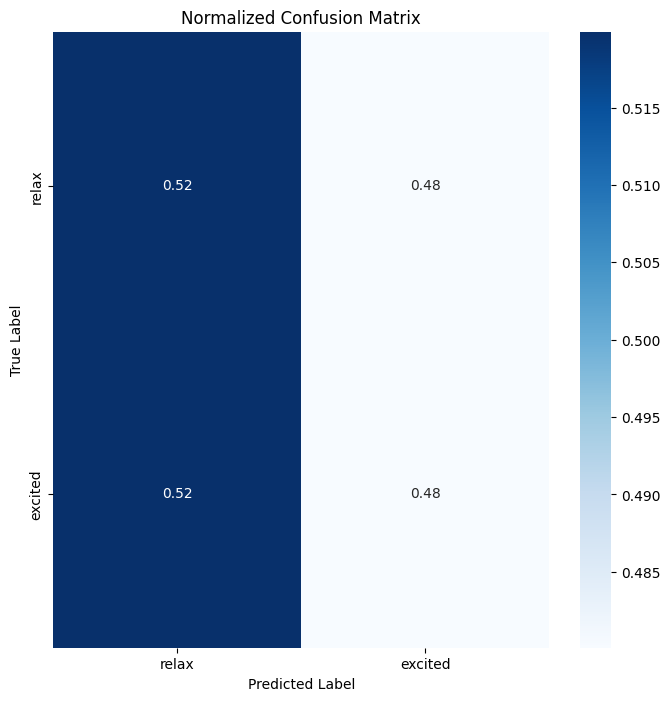

In [4]:
X = np.vstack((features_relax_samples_cleared, features_excited_samples_cleared))
y_truth = np.hstack((np.zeros(len(features_relax_samples_cleared)), np.ones(len(features_excited_samples_cleared))))

print(X.shape)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Read the model
with open('models/lda_model.pkl', 'rb') as file:
    lda_model = pickle.load(file)

# Make predictions on the test set
y_pred = lda_model.predict(X_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_truth, y_pred)
f1 = f1_score(y_truth, y_pred, average='binary')

print(f'Accuracy: {accuracy:.2f} F1 Score: {f1:.2f}')
plot_confusion_matrix(y_truth, y_pred, classes=['relax', 'excited'], normalize=True)

##### LDA classification WITH denoising

In [5]:
# load autoencoder model
denoiser = load_model('models/denoising_autoencoder_20240403-123951.h5')

# scale data
X = np.vstack((features_relax_samples_cleared, features_excited_samples_cleared))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Denoise the data
X_denoised = denoiser.predict(X_scaled)

print(X.shape, X_denoised.shape)

# convert to pandas dataframe

29/29 [==============================] - 1s 6ms/step
(904, 40) (904, 40, 1)


(904, 40)
Accuracy: 0.50 F1 Score: 0.49


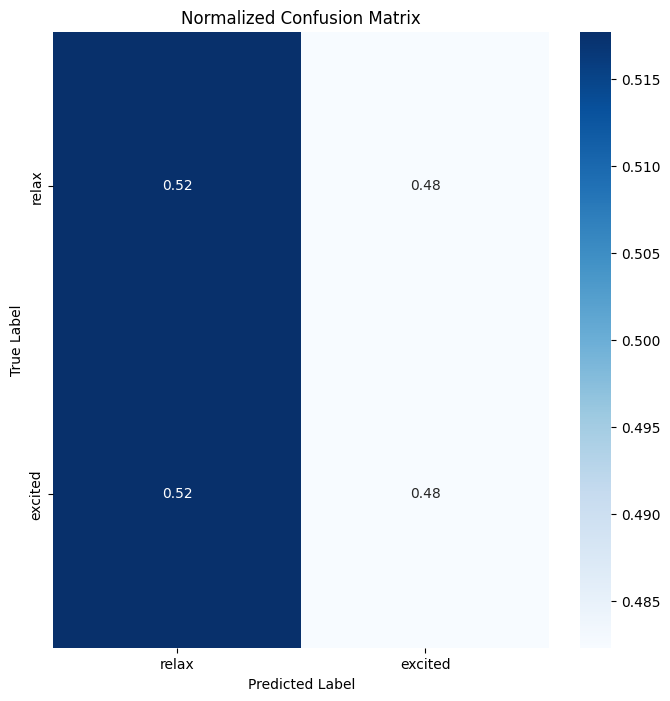

In [9]:
# squeeze the data
X_denoised = np.squeeze(X_denoised)

print(X_denoised.shape)

# Make predictions on the test set
y_pred = lda_model.predict(X_denoised)


# Calculate accuracy
accuracy = accuracy_score(y_truth, y_pred)
f1 = f1_score(y_truth, y_pred, average='binary')

print(f'Accuracy: {accuracy:.2f} F1 Score: {f1:.2f}')
plot_confusion_matrix(y_truth, y_pred, classes=['relax', 'excited'], normalize=True)